# American Gut Dataset Preprocessing Notebook

The American Gut (Amgut) dataset contains thousands of fecal microbial samples across many demographics (age, country, sex, etc). A subset of these samples come from individuals on the Autism spectrum (ASD).  However, in this dataset, the demographics of individuals with ASD can differ greatly from the demographics of the non-ASD, "control" samples. Therefore, we opted to use only a subset of control samples whose features matches that of individuals with ASD. To do this, we modified a version of propensity score matching to curate a control cohort. We then compare the distribution of features between ASD and control. Lastly, we reformat the Amgut dataset so that it is in the same format as the other studies in the meta-analysis.

<br> Our modified version of propensity score matching consists of two steps: scoring and matching. 

1. <b> Scoring step </b>: each sample is given a similarity score. This score is simply the conditional probability of cohort assignment given a vector of metadata features. 

2. <b> Matching step </b>: the similarity score from each sample in the ASD cohort is then compared with the similarity score from every control sample whose “exact matches” variables were the same. The control sample with the closest similarity score is then placed in the control cohort and removed as a possible control sample for subsequent rounds of matching. After matching every ASD sample, we obtain a control cohort of unique samples and whose sample size is the same as that of the ASD cohort. 

To do:

1. Add onehotencoder and propensity score


In [2]:
%matplotlib inline
import pandas as pd
import os, sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

from utils import PropensityScore, OneHotEncoder

In [3]:
data_directory = '../data/'
data_filename = 'amgut_data.tsv'
metadata_filename = 'amgut_metadata.txt' 

In [4]:
# quantitative and categorical variables for propensity scoring
quan_vars = ['age_years','bmi'] 
cat_vars = ['csection','country','diabetes','antibiotic_history', 'probiotic_frequency', 'prepared_meals_frequency', 'allergic_to','red_meat_frequency',
         'fermented_consumed','whole_grain_frequency','vitamin_b_supplement_frequency','plant_protein_frequency',
 'vitamin_d_supplement_frequency','flossing_frequency','vegetable_frequency','fermented_frequency','epilepsy_or_seizure_disorder']

# variables needed for exact match
exact = ['run_date', 'sample_type','sex']


## Step 1. Preprocessing

- Read amgut metadata
- include only samples with valid ASD status
- one-hot encode categorical covariates


In [5]:
# include only samples whose ASD status is either "do not have this condition" or "diagnosed by medical professional". 
valid_values = ['I do not have this condition', 'Diagnosed by a medical professional (doctor, physician assistant)']


df = pd.read_csv(os.path.join(data_directory, metadata_filename), delimiter = '\t')
df.fillna('Unknown', inplace = True) # useful to avoid error in next cell
df = df[df['asd'].isin(valid_values)]
df = df.loc[df['country'] != 'LabControl test'] # ignore lab controls

C:\Users\Eric\anaconda3\envs\precidiag\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (97,98,99,155,168,174,503) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
encoder = OneHotEncoder(covariates = cat_vars)
encoded_df = encoder.fit_transform(df)

co_vars = encoder.transformed_covariates + quan_vars

encoded_df[co_vars] = encoded_df[co_vars].apply(pd.to_numeric, errors = 'coerce')
encoded_df = encoded_df[~encoded_df[co_vars].isnull().any(axis = 1)]
encoded_df

,#SampleID,runid,linker,primer,barcode,plating,well_id,platform,run_date,orig_name,...,fermented_frequency_Unknown,fermented_frequency_not applicable,fermented_frequency_not provided,fermented_frequency_unknown,"epilepsy_or_seizure_disorder_Diagnosed by a medical professional (doctor, physician assistant)",epilepsy_or_seizure_disorder_Diagnosed by an alternative medicine practitioner,epilepsy_or_seizure_disorder_I do not have this condition,epilepsy_or_seizure_disorder_Not provided,epilepsy_or_seizure_disorder_Self-diagnosed,epilepsy_or_seizure_disorder_Unspecified
0,56608.10317.000058903,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,ATAAACGGACAT,LDG,H1,Illumina,09/18/17,58903,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,56608.10317.000059852,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,CGTCGCAGCCTT,LDG,D9,Illumina,09/18/17,59852,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,56608.10317.000059875,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,AGAGACGCGTAG,LDG,G9,Illumina,09/18/17,59875,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,56608.10317.000074646,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,ACTCACAGGAAT,LDG,C9,Illumina,09/18/17,74646,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,56608.10317.000073749,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,CTCATCATGTTC,LDG,D5,Illumina,09/18/17,73749,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,103430.10317.000115570,201106_M05314_0267_000000000-JCNCM,GT,GTGTGYCAGCMGCCGCGGTAA,TATCATATTACG,SF,A3,Illumina,11/6/20,115570,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1576,103430.10317.000115580,201106_M05314_0267_000000000-JCNCM,GT,GTGTGYCAGCMGCCGCGGTAA,GTTCATTAAACT,SF,B1,Illumina,11/6/20,115580,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1577,103430.10317.000115572,201106_M05314_0267_000000000-JCNCM,GT,GTGTGYCAGCMGCCGCGGTAA,TTCGATGCCGCA,SF,C1,Illumina,11/6/20,115572,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1578,103430.10317.000115679,201106_M05314_0267_000000000-JCNCM,GT,GTGTGYCAGCMGCCGCGGTAA,CACAACCACAAC,SF,G12,Illumina,11/6/20,115679,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Step 2. Propensity Score Matching

In [7]:
# create curated dataset of asd  and control samples
treatment_group = {'asd': 'Diagnosed by a medical professional (doctor, physician assistant)'}
propensity = PropensityScore(treatment_group = treatment_group, covariates = co_vars, exact = exact, repeat = False)
results = propensity.fit_transform(encoded_df)
results

62 entries dropped.


,#SampleID,runid,linker,primer,barcode,plating,well_id,platform,run_date,orig_name,...,fermented_frequency_Unknown,fermented_frequency_not applicable,fermented_frequency_not provided,fermented_frequency_unknown,"epilepsy_or_seizure_disorder_Diagnosed by a medical professional (doctor, physician assistant)",epilepsy_or_seizure_disorder_Diagnosed by an alternative medicine practitioner,epilepsy_or_seizure_disorder_I do not have this condition,epilepsy_or_seizure_disorder_Not provided,epilepsy_or_seizure_disorder_Self-diagnosed,epilepsy_or_seizure_disorder_Unspecified
1,56608.10317.000059852,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,CGTCGCAGCCTT,LDG,D9,Illumina,09/18/17,59852,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,56608.10317.000073749,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,CTCATCATGTTC,LDG,D5,Illumina,09/18/17,73749,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,56608.10317.000072136,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,ACACGTTTGGGT,LDG,D8,Illumina,09/18/17,72136,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
11,56608.10317.000073612,170905_M05314_0025_000000000-B5KBR,GT,GTGTGYCAGCMGCCGCGGTAA,TCTAACGAGTGC,LDG,B9,Illumina,09/18/17,73612,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
14,56754.10317.000021574,unknown,GT,GTGTGYCAGCMGCCGCGGTAA,TGAGACCCTACA,unknown,E9,Illumina,06/30/15,unknown,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,97155.10317.000108091,200315_M05314_0238_000000000-CMPLF,GT,GTGTGYCAGCMGCCGCGGTAA,ACTAAAGCAAAC,SF,F7,Illumina,3/15/20,108091,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1545,97155.10317.000108093,200315_M05314_0238_000000000-CMPLF,GT,GTGTGYCAGCMGCCGCGGTAA,TGAGTCATTGAG,SF,A7,Illumina,3/15/20,108093,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1549,97155.10317.000108092,200315_M05314_0238_000000000-CMPLF,GT,GTGTGYCAGCMGCCGCGGTAA,CTTGCTCATAAT,SF,G7,Illumina,3/15/20,108092,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1568,103430.10317.000115678,201106_M05314_0267_000000000-JCNCM,GT,GTGTGYCAGCMGCCGCGGTAA,TCGTTGGGACTA,SF,H12,Illumina,11/6/20,115678,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
# save the dataset
results.to_csv(os.path.join(data_directory,'temp_amgut_meta.csv'), sep = '\t', index = True)

## Step 3. Validate distributions of covariates are similar between ASD and control groups

In [9]:
asd = df.loc[df['#SampleID'].isin(results.loc[results['asd'] == valid_values[1]]['#SampleID'])]
control = df.loc[df['#SampleID'].isin(results.loc[results['asd'] == valid_values[0]]['#SampleID'])]

C:\Users\Eric\anaconda3\envs\precidiag\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Eric\anaconda3\envs\precidiag\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


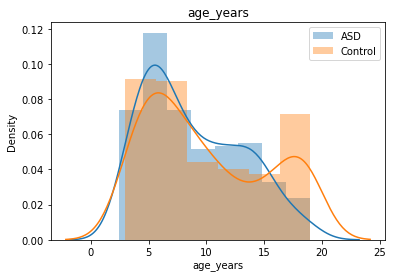

In [10]:
# plot age distributions
var = quan_vars[0]
sns.distplot(asd[var], label = 'ASD')
sns.distplot(control[var], label = 'Control')
plt.legend()
plt.title(var)
plt.savefig(f'Amgut_{var}.pdf', dpi = 1200)
plt.show()

C:\Users\Eric\AppData\Local\Temp/ipykernel_4156/849406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd[var] = asd[var].astype('float32')
C:\Users\Eric\AppData\Local\Temp/ipykernel_4156/849406.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control[var] = control[var].astype('float32')
C:\Users\Eric\anaconda3\envs\precidiag\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

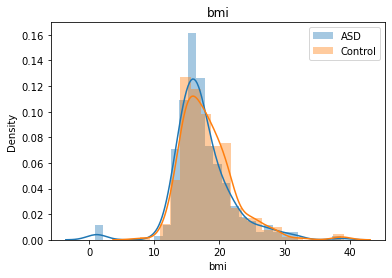

In [11]:
# plot bmi distributions
var = quan_vars[1]
asd[var] = asd[var].astype('float32')
control[var] = control[var].astype('float32')
sns.distplot(asd[asd[var] < 45][var], label = 'ASD') 
sns.distplot(control[control[var] < 45][var], label = 'Control')
plt.legend()
plt.title(var)
plt.savefig(f'Amgut_{var}.pdf', dpi = 1200)
plt.show()

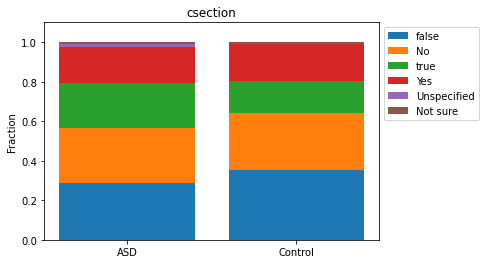

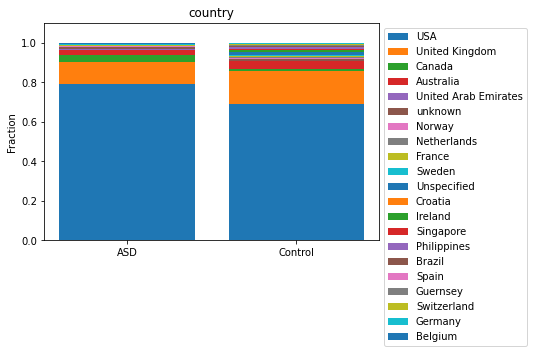

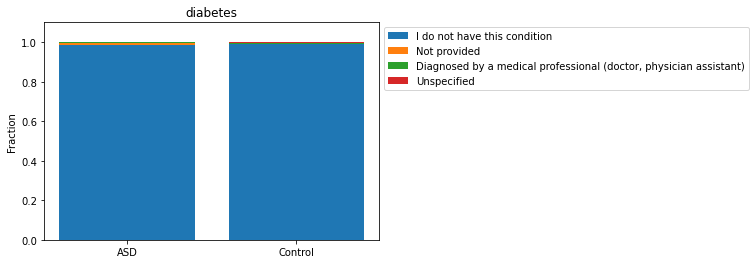

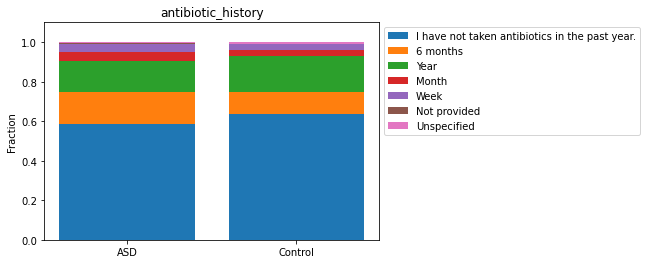

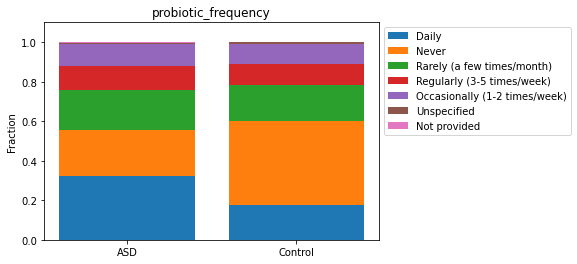

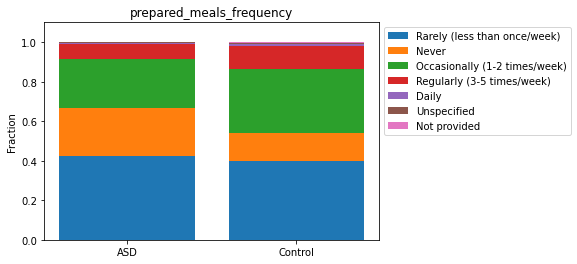

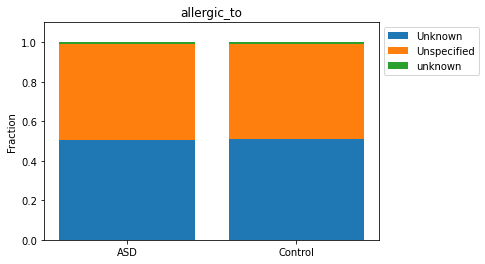

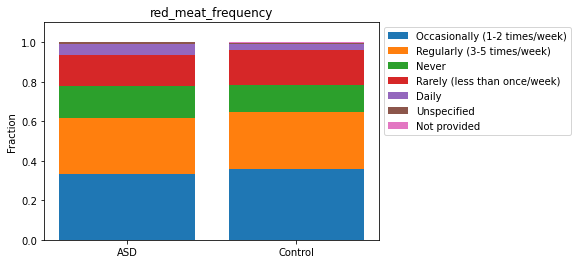

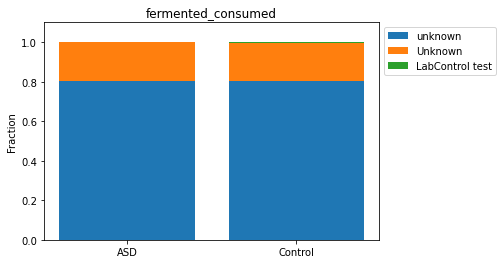

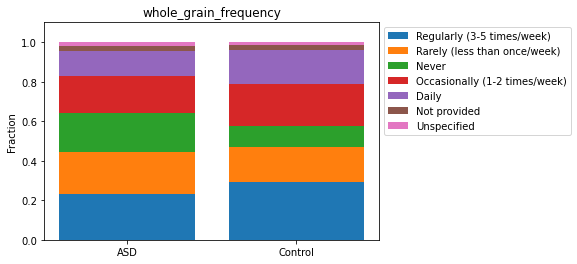

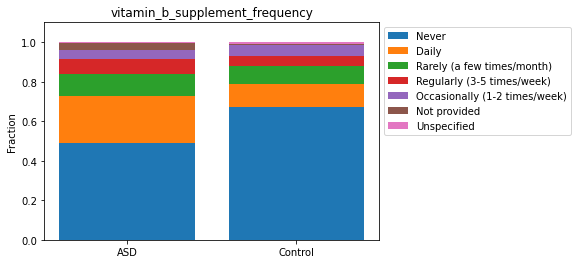

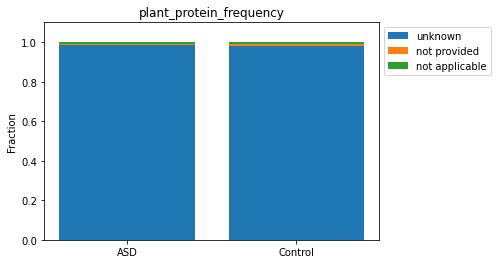

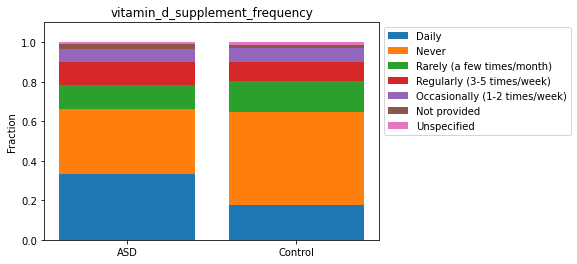

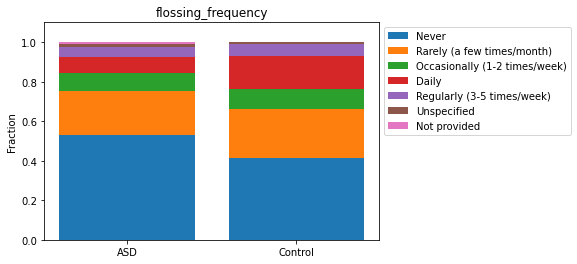

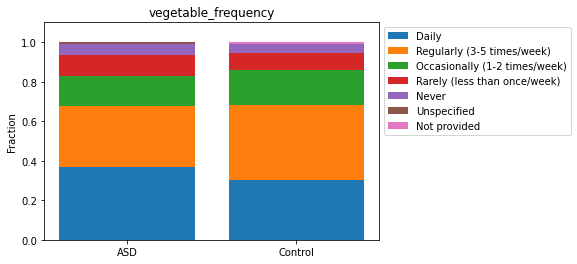

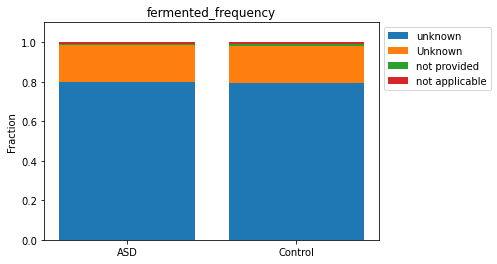

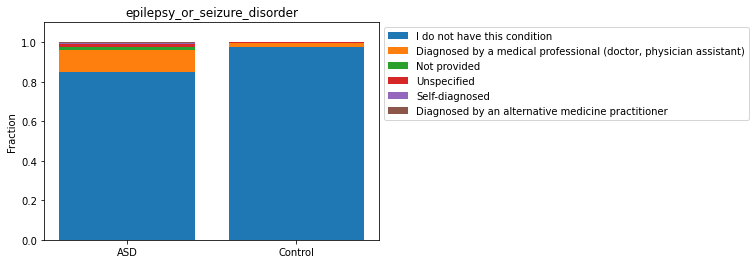

In [12]:
normalized = True # to use normalized (sum to 1) instead of raw counts

for var in cat_vars:

    temp = pd.concat([asd[var].value_counts(), control[var].value_counts()], axis = 1).replace(np.nan, 0)
    temp.columns = ['ASD', 'Control']
    if normalized:
        temp /= temp.sum(axis = 0) # normalized
        plt.ylim([0, 1.1])
    running = np.array([0, 0])
    for name, row in temp.iterrows():
        plt.bar(temp.columns, row, bottom = running, label = name)
        running = running + row.values
    plt.legend(bbox_to_anchor = (1, 1))
    plt.title(var)
    plt.ylabel('Fraction')
    plt.savefig(f'Normalized_Amgut_Categorical_{var}.pdf', dpi = 1200)
    plt.show()

## Step 4. Reformat amgut data and select only curated samples

In [13]:
# open the data file
data = pd.read_csv(os.path.join(data_directory, data_filename), delimiter = '\t')
data.set_index('taxa', inplace = True)
data = data.T

# change taxonomy formatting
data.columns = [col.replace("', '", '; ').replace("'", '') for col in data.columns] 

# select only samples in the curated cohort
data = data.loc[results.loc[results['#SampleID'].isin(data.index)]['#SampleID']]

# save
data.to_csv(os.path.join(data_directory, 'amgut_data_processed.csv'), sep = '\t', index = True)

In [14]:
# include only certain features of metadata
metadata = results.copy()
metadata.rename(columns = {'asd': 'Status'}, inplace = True)
metadata.replace(to_replace = {'Status': {valid_values[0]: 'Control', valid_values[1]: 'ASD'}}, inplace = True)
metadata = metadata.loc[metadata['#SampleID'].isin(data.index)]
metadata.to_csv(os.path.join(data_directory, 'amgut_metadata_processed.csv'), sep = '\t', index = True)